# Plotting vector polygon data with GeoPandas and Matplotlib

Data used:

- <https://ec.europa.eu/eurostat/web/nuts/background>

Install the following packages:

- cartopy
- geopandas
- scipy
- pooch
- mapclassify
- contextily

In [1]:
import os
from zipfile import BadZipFile, ZipFile

import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.pyplot as plt
import pooch
from matplotlib import patheffects
import numpy as np
import matplotlib.patches as mpatches
import contextily as cx

In [2]:
# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

## Data

In [3]:
URL = (
    "https://gisco-services.ec.europa.eu/distribution/v2/nuts/download/"
    "ref-nuts-2021-01m.shp.zip"
)
FILE_NAME = "ref-nuts-2021-01m.shp.zip"
SUB_DIR = os.path.join("data", "NUTS")
DATA_FILE = os.path.join(SUB_DIR, FILE_NAME)
os.makedirs(SUB_DIR, exist_ok=True)

In [4]:
# download data if necessary
if not os.path.isfile(os.path.join(SUB_DIR, FILE_NAME)):
    pooch.retrieve(
        url=URL, known_hash=None, fname=FILE_NAME, path=SUB_DIR
    )

In [5]:
# extract the archive
try:
    z = ZipFile(DATA_FILE)
    z.extractall(SUB_DIR)
except BadZipFile:
    print("There were issues with the file", DATA_FILE)

In [6]:
DATA_FILE = os.path.join(SUB_DIR, "NUTS_RG_01M_2021_4326_LEVL_0.shp.zip")

In [7]:
nuts = gpd.read_file(f"zip://{DATA_FILE}!NUTS_RG_01M_2021_4326_LEVL_0.shp")

In [8]:
nuts.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
# clip to European regions only (i.e. no FR overseas territories)
nuts = gpd.clip(nuts, mask=(-25, 27, 45, 72))

In [10]:
# reproject to a projected CRS for plotting
# see https://scitools.org.uk/cartopy/docs/latest/reference/projections.html
# for more projections
nuts.to_crs(ccrs.TransverseMercator(), inplace=True)

In [11]:
nuts.crs

<Projected CRS: +proj=tmerc +ellps=WGS84 +lon_0=0.0 +lat_0=0.0 +k= ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Transverse Mercator
Datum: Unknown based on WGS 84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
# generate some random data for the choropleth map
nuts["RAND"] = np.random.default_rng(seed=9999).integers(low=-20, high=20, size=len(nuts))
nuts.loc[33, "RAND"] = np.nan

In [13]:
nuts

,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry,RAND
13,FR,0,FR,France,France,0,0,0,FR,"MULTIPOLYGON (((781078.266 4678908.583, 781061...",-17.0
11,ES,0,ES,España,España,0,0,0,ES,"MULTIPOLYGON (((349305.702 4444427.773, 350213...",13.0
21,MT,0,MT,Malta,Malta,0,0,0,MT,"MULTIPOLYGON (((1299742.839 4082200.794, 13005...",-13.0
36,PT,0,PT,Portugal,Portugal,0,0,0,PT,"MULTIPOLYGON (((-678656.554 4663814.712, -6776...",10.0
18,IT,0,IT,Italia,Italia,0,0,0,IT,"MULTIPOLYGON (((929228.578 5288152.491, 928973...",-10.0
27,SI,0,SI,Slovenija,Slovenija,0,0,0,SI,"MULTIPOLYGON (((1250315.603 5308161.435, 12511...",-10.0
7,CH,0,CH,Schweiz/Suisse/Svizzera,Schweiz/Suisse/Svizzera,0,0,0,CH,"POLYGON ((645034.765 5332359.829, 645704.061 5...",4.0
28,LI,0,LI,Liechtenstein,Liechtenstein,0,0,0,LI,"POLYGON ((729362.412 5269204.766, 729777.513 5...",11.0
8,AT,0,AT,Österreich,Österreich,0,0,0,AT,"MULTIPOLYGON (((786433.762 5322267.432, 787925...",-3.0
1,CZ,0,CZ,Česko,Česko,0,0,0,CZ,"POLYGON ((1013929.203 5757600.310, 1014445.137...",-11.0


## Plot

### Using colorbar of absolute values

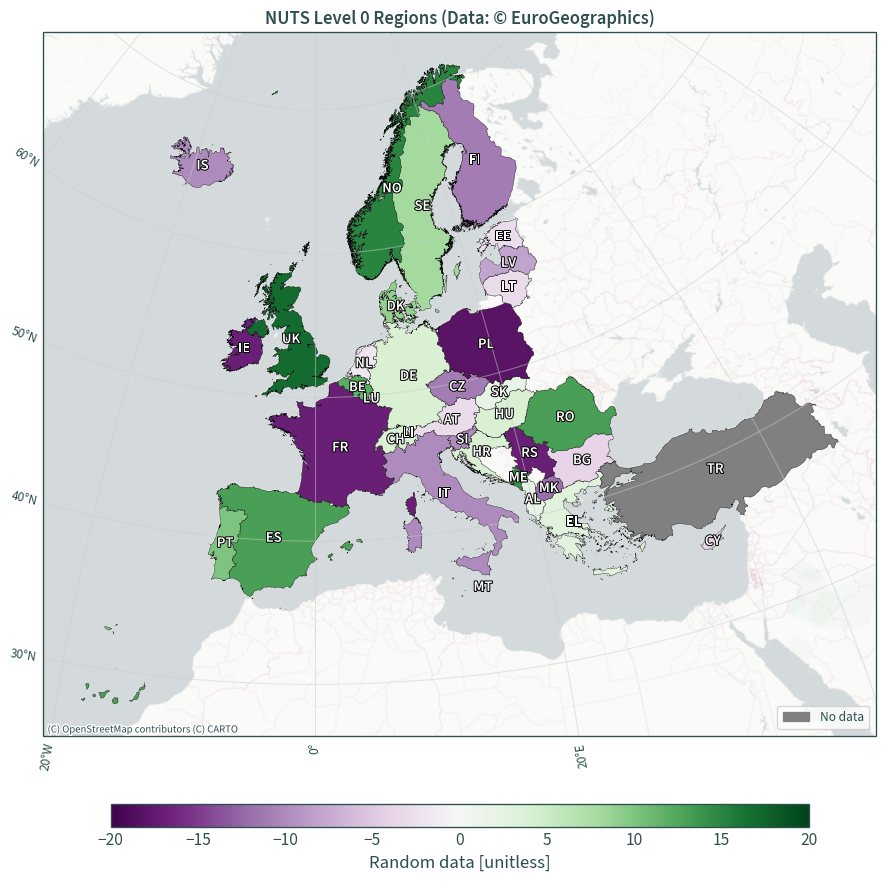

In [14]:
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.TransverseMercator())

# specify the numeric data to plot in the column keyword
# see here for colourmaps:
# https://matplotlib.org/stable/gallery/color/colormap_reference.html
nuts.plot(
    edgecolor="black",
    linewidth=0.25,
    column="RAND",
    legend=True,
    cmap="PRGn",
    legend_kwds={
        "label": "Random data [unitless]",
        "orientation": "horizontal",
        "shrink": 0.75, "pad": 0.075, "aspect": 30,
    },
    vmax=20,  # colourbar max value
    vmin=-20,  # colourbar min value
    missing_kwds={"color": "grey",},
    ax=ax,
)

# if you have entries with missing data, configure missing_kwds above and
# include the following legend
ax.legend(handles=[mpatches.Patch(color="grey", label="No data")], loc="lower right")

# optionally add labels directly to the map
# country codes used here as an example
map_labels = zip(zip(nuts.centroid.x, nuts.centroid.y), nuts["CNTR_CODE"])
for xy, lab in map_labels:
    ax.annotate(
        text=lab, xy=xy, rotation=0, va="center", ha="center",
        path_effects=[patheffects.withStroke(linewidth=1.5, foreground="black")],
        fontweight="semibold", fontsize=11, color="white"
    )

# optionally add gridlines
ax.gridlines(draw_labels={"bottom": "x", "left": "y"}, alpha=0.5)

# optionally add a basemap
# https://contextily.readthedocs.io/en/latest/
cx.add_basemap(
    ax, source=cx.providers.CartoDB.PositronNoLabels,
    crs=ccrs.TransverseMercator(), zoom=5
)

plt.title("NUTS Level 0 Regions (Data: © EuroGeographics)")
plt.tight_layout()
plt.show()

### Using quantiles classification

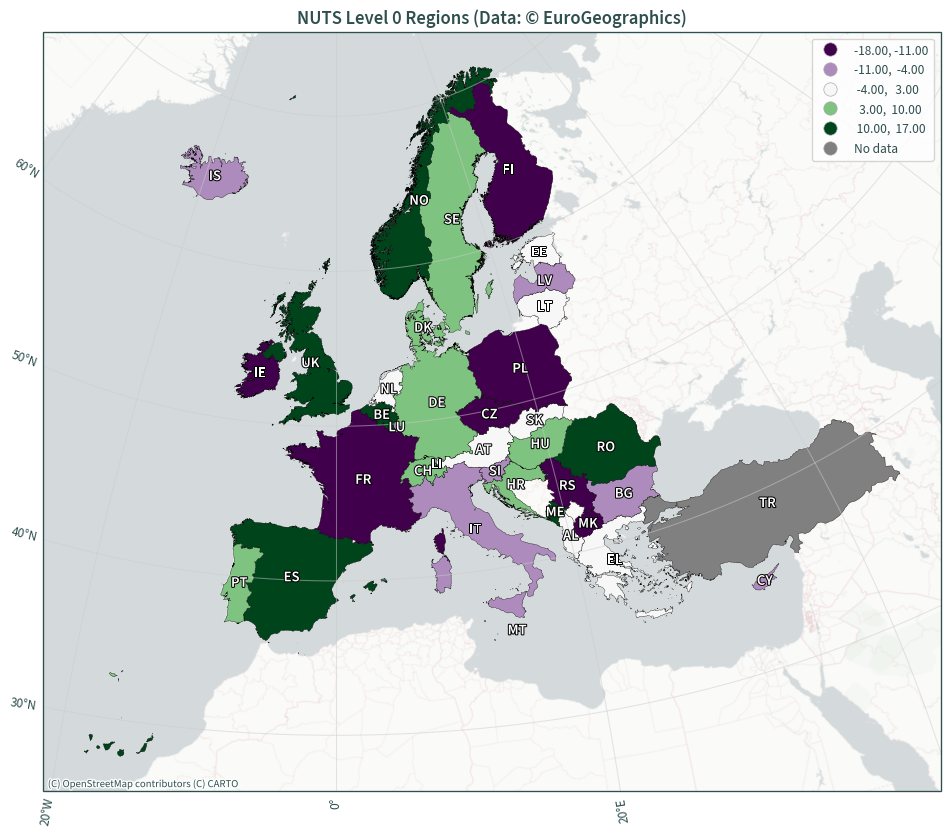

In [15]:
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.TransverseMercator())

# specify the numeric data to plot in the column keyword
# see here for colourmaps:
# https://matplotlib.org/stable/gallery/color/colormap_reference.html
# see here for classification methods
# https://geopandas.org/en/stable/docs/user_guide/mapping.html#choosing-colors
nuts.plot(
    edgecolor="black",
    linewidth=0.25,
    column="RAND",
    legend=True,
    cmap="PRGn",
    missing_kwds={"color": "grey", "label": "No data"},
    ax=ax,
    scheme="quantiles",
)

for legend_handle in ax.get_legend().legend_handles:
    legend_handle.set_markeredgewidth(0.5)
    legend_handle.set_markeredgecolor("darkgrey")

# optionally add labels directly to the map
# country codes used here as an example
map_labels = zip(zip(nuts.centroid.x, nuts.centroid.y), nuts["CNTR_CODE"])
for xy, lab in map_labels:
    ax.annotate(
        text=lab, xy=xy, rotation=0, va="center", ha="center",
        path_effects=[patheffects.withStroke(linewidth=1.5, foreground="black")],
        fontweight="semibold", fontsize=11, color="white"
    )

# optionally add gridlines
ax.gridlines(draw_labels={"bottom": "x", "left": "y"}, alpha=0.5)

# optionally add a basemap
# https://contextily.readthedocs.io/en/latest/
cx.add_basemap(
    ax, source=cx.providers.CartoDB.PositronNoLabels,
    crs=ccrs.TransverseMercator(), zoom=5
)

plt.title("NUTS Level 0 Regions (Data: © EuroGeographics)")
plt.tight_layout()
plt.show()